In [57]:
from qiskit import *
from qiskit.visualization import *

import numpy as np
import matplotlib.pyplot as plt

In [58]:
from qiskit_ibm_provider import IBMProvider

provider = IBMProvider()

In [59]:
# sim = Aer.get_backend('qasm_simulator')
from qiskit.providers.fake_provider import FakeManilaV2

sim = FakeManilaV2()

# Algorithme de Deutsch - Josza

Posons une fonction $f:\{0,1\}^n \rightarrow \{0,1\}$. Cette fonction prend donc $n$ bits comme input, et retourne soit 0 soit 1. De plus, cette fonction et soit constante (0 ou 1 $\forall x$) ou équilibrée (0 pour la moitié des entrées, 1 pour le reste).

Cette fonction va être notre oracle. Pour déterminer la nature de la fonction de manière classique, on devra l'appeler $k = 2^{n-1}+1$ (tester une fois de plus que la moitié des valeurs).

On va montrer qu'avec un circuit quantique on peut le faire avec un unique appel de l'oracle.

## Première version

Deutsch va dans un article présenter le cas pour n = 1.

### Fonction équilibrée

$f(1) = 1$ et $f(0) = 0$

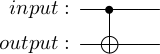

In [60]:
inpreg = QuantumRegister(1, 'input')
outreg = QuantumRegister(1, 'output')
d_balanced_fun_circ = QuantumCircuit(inpreg, outreg)

d_balanced_fun_circ.cx(inpreg[0], outreg[0])

d_bal_fun = d_balanced_fun_circ.to_gate(label='Oracle')

d_balanced_fun_circ.draw()

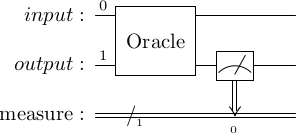

{'0': 1014, '1': 10}


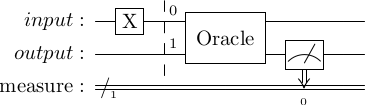

{'1': 979, '0': 45}


In [61]:
cmeasure = ClassicalRegister(1, 'measure')

for l in [0,1]:
    test_balanced_fun_circ = QuantumCircuit(inpreg, outreg, cmeasure)
    if l == 1:
        test_balanced_fun_circ.x(inpreg[0])
        test_balanced_fun_circ.barrier()

    test_balanced_fun_circ.append(d_bal_fun, [0,1])

    test_balanced_fun_circ.measure(outreg[0], cmeasure[0])

    display(test_balanced_fun_circ.draw())

    job = execute(test_balanced_fun_circ, sim, shots=1024)
    result = job.result()
    counts = result.get_counts(test_balanced_fun_circ)

    print(counts)

### Foction constante

$f(0) = 0$ et $f(1)=0$

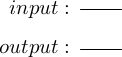

In [62]:
d_cons_fun_circ = QuantumCircuit(inpreg, outreg)

d_con_fun = d_cons_fun_circ.to_gate(label='Oracle')

d_cons_fun_circ.draw()

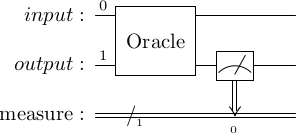

{'0': 1018, '1': 6}


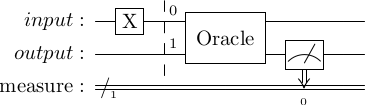

{'0': 1014, '1': 10}


In [63]:
for l in [0,1]:
    test_con_fun_circ = QuantumCircuit(inpreg, outreg, cmeasure)
    if l == 1:
        test_con_fun_circ.x(inpreg[0])
        test_con_fun_circ.barrier()

    test_con_fun_circ.append(d_con_fun, [0,1])

    test_con_fun_circ.measure(outreg[0], cmeasure[0])

    display(test_con_fun_circ.draw())

    job = execute(test_con_fun_circ, sim, shots=1024)
    result = job.result()
    counts = result.get_counts(test_con_fun_circ)

    print(counts)

### Test de l'algorithme

Dans le cas où $f$ est constante, la sortie est 0, et sinon c'est 1. On voit que cela fonctionne bien dans ce cas.

In [64]:
oracles = [d_bal_fun, d_con_fun]

for oracle in oracles:
    deutsch_circ = QuantumCircuit(inpreg, outreg, cmeasure)
    
    # Initialize the circuit
    deutsch_circ.x(outreg[0])
    deutsch_circ.barrier()
    deutsch_circ.h(inpreg[0])
    deutsch_circ.h(outreg[0])
    
    # Apply the oracle
    deutsch_circ.append(oracle, [0,1])
    
    # Measure the output
    deutsch_circ.h(inpreg[0])
    deutsch_circ.measure(inpreg[0], cmeasure[0])
    
    print(deutsch_circ.draw(output='latex_source'))
    
    # Execute the circuit
    counts = execute(deutsch_circ, sim, shots=1024).result().get_counts()
    print(counts)

\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{
\Qcircuit @C=1.0em @R=0.2em @!R { \\
	 	\nghost{{input} :  } & \lstick{{input} :  } & \qw \barrier[0em]{1} & \qw & \gate{\mathrm{H}} & \multigate{1}{\mathrm{Oracle}}_<<<{0} & \gate{\mathrm{H}} & \meter & \qw & \qw\\
	 	\nghost{{output} :  } & \lstick{{output} :  } & \gate{\mathrm{X}} & \qw & \gate{\mathrm{H}} & \ghost{\mathrm{Oracle}}_<<<{1} & \qw & \qw & \qw & \qw\\
	 	\nghost{\mathrm{{measure} :  }} & \lstick{\mathrm{{measure} :  }} & \lstick{/_{_{1}}} \cw & \cw & \cw & \cw & \cw & \dstick{_{_{\hspace{0.0em}0}}} \cw \ar @{<=} [-2,0] & \cw & \cw\\
\\ }}
\end{document}
{'1': 973, '0': 51}
\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{
\Qcircuit @C=1.0em @R=0.2em @!R { \\
	 	\nghost{{input} :  } & \lstick{{input} :  } & \qw \barrier[0em]{1} & \qw & \gate{\mathrm{H}} & \multigat

## Version général

L'algorithme de Deutsch - Josza est la version généralisée de ce problème.

In [65]:
def balanced_oracle(n):
    """Create a balanced oracle for n qubits."""
    oracle_qc = QuantumCircuit(n+1)
    for qubit in range(n):
        oracle_qc.cx(qubit, n)
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle"
    return oracle_gate

def constant_oracle(n):
    """Create a constant oracle for n qubits."""
    oracle_qc = QuantumCircuit(n+1)
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle"
    return oracle_gate

In [66]:
def deutsch_josza(n, oracle):
    """Create a Deutsch-Josza circuit with n qubits and an oracle."""
    dj_circuit = QuantumCircuit(n+1, n)
    dj_circuit.x(n)
    dj_circuit.h(n)
    for qubit in range(n):
        dj_circuit.h(qubit)
    dj_circuit.append(oracle, range(n+1))
    for qubit in range(n):
        dj_circuit.h(qubit)
    dj_circuit.measure(range(n), range(n))
    return dj_circuit

In [67]:
# Create a function to verifiy if the oracle is balanced or constant
def verifiy(oracle, n, debug=False):
    """Verify if the oracle is balanced or constant."""
    res = {'0': 0, '1': 0}
    
    for i in range(2**n):
        bina = bin(i)[2:]
        verif_circ = QuantumCircuit(n+1, 1)
        for j in range(len(bina)):
            if bina[::-1][j] == '1':
                verif_circ.x(j)
                
        verif_circ.append(oracle, range(n+1))
        
        verif_circ.measure(n, 0)
        
        if debug:
            display(verif_circ.draw())
        
        counts = execute(verif_circ, sim, shots=1024).result().get_counts()
        if debug:
            print(counts)
        res['0'] += counts.get('0', 0)
        res['1'] += counts.get('1', 0)
            
    print(res)
    
for i in range(1,5):
    print('Balanced oracle with', i, 'qubits')
    verifiy(balanced_oracle(i), i)

Balanced oracle with 1 qubits
{'0': 1062, '1': 986}
Balanced oracle with 2 qubits
{'0': 2092, '1': 2004}
Balanced oracle with 3 qubits
{'0': 4225, '1': 3967}
Balanced oracle with 4 qubits
{'0': 8425, '1': 7959}


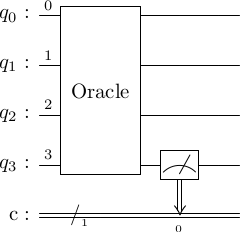

{'0': 1013, '1': 11}


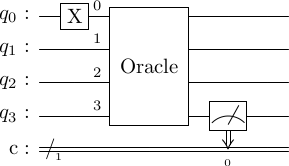

{'0': 1021, '1': 3}


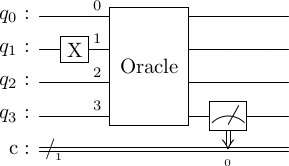

{'0': 1010, '1': 14}


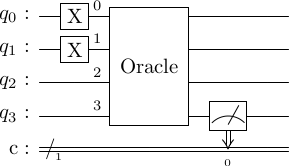

{'0': 1010, '1': 14}


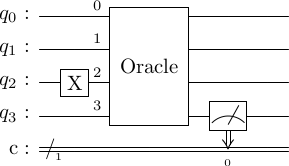

{'0': 1018, '1': 6}


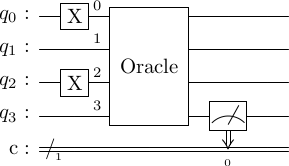

{'0': 1017, '1': 7}


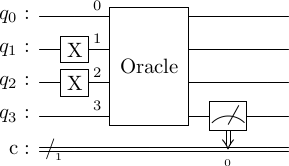

{'0': 1016, '1': 8}


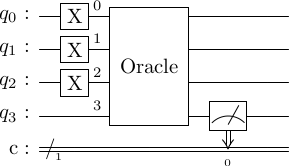

{'0': 1006, '1': 18}
{'0': 8111, '1': 81}
---------------------


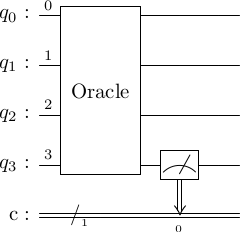

{'0': 1012, '1': 12}


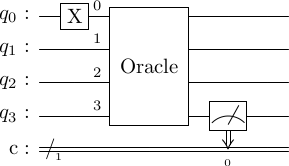

{'1': 973, '0': 51}


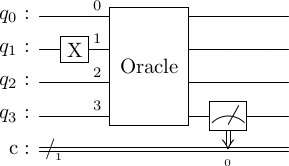

{'1': 967, '0': 57}


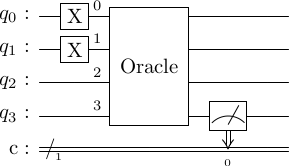

{'0': 995, '1': 29}


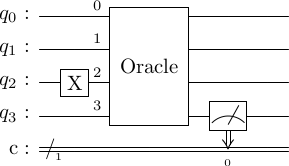

{'1': 964, '0': 60}


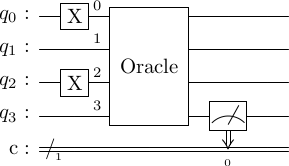

{'0': 1002, '1': 22}


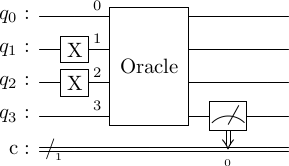

{'0': 996, '1': 28}


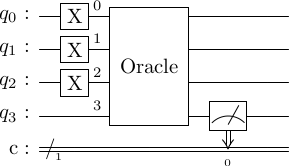

{'1': 963, '0': 61}
{'0': 4234, '1': 3958}


In [68]:
verifiy(constant_oracle(3), 3, debug=True)
print('---------------------')
verifiy(balanced_oracle(3), 3, debug=True)

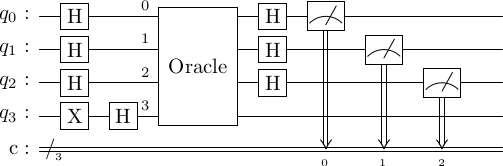

{'111': 822, '011': 53, '001': 8, '101': 77, '010': 3, '100': 10, '110': 49, '000': 2}


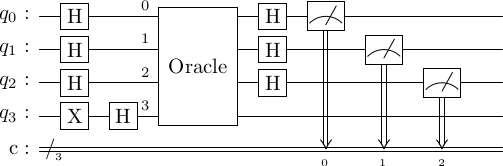

{'000': 992, '100': 11, '010': 13, '001': 8}


In [69]:
# Tester avec n = 3
n = 3

# Tester avec oracle = balanced_oracle(n)
oracle = balanced_oracle(n)
circ = deutsch_josza(n, oracle)
display(circ.draw())
counts = execute(circ, sim, shots=1024).result().get_counts()
print(counts)

# De même avec oracle = constant_oracle(n)
oracle = constant_oracle(n)
circ = deutsch_josza(n, oracle)
display(circ.draw())
counts = execute(circ, sim, shots=1024).result().get_counts()
print(counts)

Oracle with 1 qubits


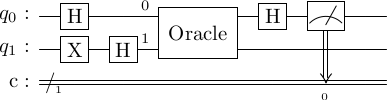

{'1': 972, '0': 52}


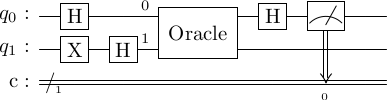

{'0': 1018, '1': 6}
Oracle with 2 qubits


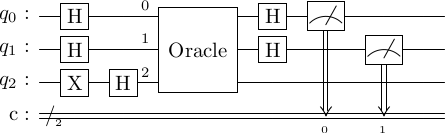

{'11': 928, '10': 54, '01': 37, '00': 5}


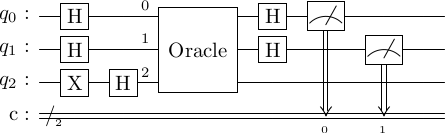

{'00': 1001, '10': 15, '01': 8}
Oracle with 3 qubits


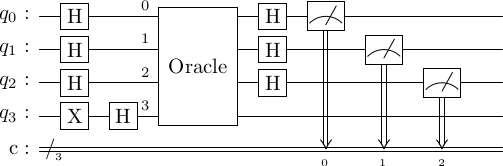

{'111': 864, '101': 57, '011': 47, '010': 2, '110': 31, '001': 20, '000': 1, '100': 2}


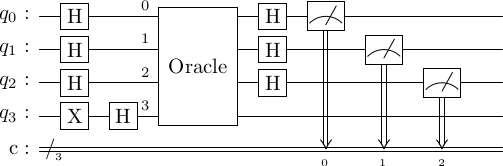

{'000': 987, '010': 12, '100': 17, '001': 7, '011': 1}
Oracle with 4 qubits


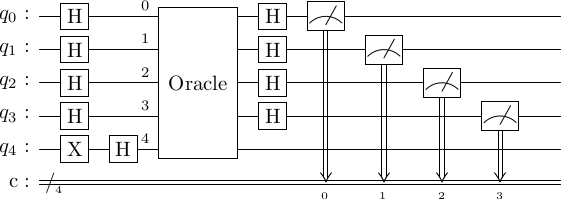

{'1101': 209, '1111': 638, '1011': 46, '0101': 6, '1110': 43, '0111': 32, '1001': 16, '0001': 7, '0110': 3, '0011': 8, '1100': 10, '0000': 3, '1010': 3}


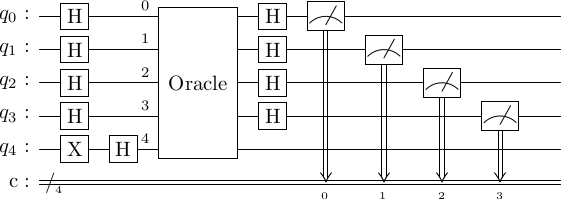

{'0000': 940, '1000': 47, '0001': 9, '0010': 15, '0100': 13}


In [70]:
for i in range(1, 5):
    print('Oracle with', i, 'qubits')
    for oracle in [balanced_oracle(i), constant_oracle(i)]:
        circ = deutsch_josza(i, oracle)
        display(circ.draw())
        counts = execute(circ, sim, shots=1024).result().get_counts()
        print(counts)